# Neural Machine Translation with Attention

Advanced Learning Fall 2024.   
Last updated: 2025-01-12


For SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 316133081
~~~

~~~
STUDENT GIT LINK: https://github.com/amihaysh/assignment_3.git
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2024_ID_[000000000].html`   




In this problem set we are going to jump into the depths of `seq2seq` and `attention` and build a couple of PyTorch translation mechanisms with some  twists.     


*   Part 1 consists of a somewhat unorthodox `seq2seq` model for simple arithmetics
*   Part 2 consists of an `seq2seq - attention` language translation model. We will use it for Hebrew and English.  


---

A **seq2seq** model (sequence-to-sequence model) is a type of neural network designed specifically to handle sequences of data. The model converts input sequences into other sequences of data. This makes them particularly useful for tasks involving language, where the input and output are naturally sequences of words.

Here's a breakdown of how `seq2seq` models work:

* The encoder takes the input sequence, like a sentence in English, and processes it to capture its meaning and context.

* information is then passed to the decoder, which uses it to generate the output sequence, like a translation in French.

* Attention mechanism (optional): Some `seq2seq` models also incorporate an attention mechanism. This allows the decoder to focus on specific parts of the input sequence that are most relevant to generating the next element in the output sequence.

`seq2seq` models are used in many natural language processing (NLP) tasks.



imports: (feel free to add)

In [ ]:
# from __future__ import unicode_literals, print_function, division
# from io import open
# import unicodedata
import re
import random
import unicodedata

import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


from keras.models import Sequential,Model
from keras.layers import LSTM, TimeDistributed, RepeatVector, Dense, Attention,Input, Add
from keras.callbacks import Callback

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


## Part 1: Seq2Seq Arithmetic model

**Using RNN `seq2seq` model to "learn" simple arithmetics!**

> Given the string "54-7", the model should return a prediction: "47".  
> Given the string "10+20", the model should return a prediction: "30".


- Watch Lukas Biewald's short [video](https://youtu.be/MqugtGD605k?si=rAH34ZTJyYDj-XJ1) explaining `seq2seq` models and his toy application (somewhat outdated).
- You can find the code for his example [here](https://github.com/lukas/ml-class/blob/master/videos/seq2seq/train.py).    



1.1) Using Lukas' code, implement a `seq2seq` network that can learn how to solve **addition AND substraction** of two numbers of maximum length of 4, using the following steps (similar to the example):      

* Generate data; X: queries (two numbers), and Y: answers   
* One-hot encode X and Y,
* Build a `seq2seq` network (with LSTM, RepeatVector, and TimeDistributed layers)
* Train the model.
* While training, sample from the validation set at random so we can visualize the generated solutions against the true solutions.    

Notes:  
* The code in the example is quite old and based on Keras. You might have to adapt some of the code to overcome methods/code that is not supported anymore. Hint: for the evaluation part, review the type and format of the "correct" output - this will help you fix the unsupported "model.predict_classes".
* Please use the parameters in the code cell below to train the model.     
* Instead of using a `wandb.config` object, please use a simple dictionary instead.   
* You don't need to run the model for more than 50 iterations (epochs) to get a gist of what is happening and what the algorithm is doing.
* Extra credit if you can implement the network in PyTorch (this is not difficult).    
* Extra credit if you are able to significantly improve the model.

1.2).

a) Do you think this model performs well?  Why or why not?     
b) What are its limitations?   
c) What would you do to improve it?    
d) Can you apply an attention mechanism to this model? Why or why not?   

a)The model may not perform well initially, as it is a basic sequence-to-sequence architecture with LSTM layers, which can struggle to generalize for complex tasks. Given that it's working with arithmetic operations, it may need more sophisticated techniques or data augmentation to generalize better

b)It may struggle with long sequences or more intricate operations due to the inherent limitations of LSTMs. Also
the model uses a simple one-hot encoding, which may not capture the underlying structure of numbers effectively.

c)Increase the dataset size or use more varied data to help the model generalize better.

d)Yes

1.3).  

Add attention to the model. Evaluate the performance against the `seq2seq` you trained above. Which one is performing better?

1.4)

Using any neural network architecture of your liking, build  a model with the aim to beat the best performing model in 1.1 or 1.3. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [ ]:
config = {}
config["training_size"] = 40000
config["digits"] = 4
config["hidden_size"] = 128
config["batch_size"] = 128
config["iterations"] = 50
chars = '0123456789-+ '

SOLUTION:

In [ ]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        x = x.astype(int)
        return ''.join(self.indices_char[i] for i in x.flatten())

maxlen = config["digits"] + 1 + config["digits"]
chars = '0123456789-+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
while len(questions) < config["training_size"]:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                            for i in range(np.random.randint(1, config["digits"] + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q_add = '{}+{}'.format(a, b)
    q_sub = '{}-{}'.format(a, b)
    query_add = q_add + ' ' * (maxlen - len(q_add))
    query_sub = q_sub + ' ' * (maxlen - len(q_sub))
    ans_add = str(a + b) + ' ' * (config["digits"] + 1 - len(str(a + b)))
    ans_sub = str(a - b) + ' ' * (config["digits"] + 1 - len(str(a - b)))
    questions.append(query_add)
    expected.append(ans_add)
    questions.append(query_sub)
    expected.append(ans_sub)

x = np.zeros((len(questions), maxlen, len(chars)), dtype=np.bool_)
y = np.zeros((len(questions), config["digits"] + 1, len(chars)), dtype=np.bool_)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, config["digits"] + 1)

indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

model = Sequential()
model.add(LSTM(config["hidden_size"], input_shape=(maxlen, len(chars))))
model.add(RepeatVector(config["digits"] + 1))
model.add(LSTM(config["hidden_size"], return_sequences=True))
model.add(TimeDistributed(Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

class PredictCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        for i in range(10):
            ind = np.random.randint(0, len(x_val))
            rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
            preds = model.predict([rowx, rowy[:, :-1]], verbose=0)
            q = ctable.decode(rowx[0])
            correct = ctable.decode(rowy[0])
            guess = ctable.decode(preds[0], calc_argmax=True)
            print(f'Q: {q} T: {correct} Guess: {guess} {"☑" if correct == guess else "☒"}')

for iteration in range(1, config["iterations"] + 1):
    model.fit(x_train, y_train,
              batch_size=config["batch_size"],
              epochs=1,
              validation_data=(x_val, y_val),
              callbacks=[PredictCallback()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


281/282 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3014 - loss: 2.0533Q: 1527-8    T: 1519  Guess: 118   ☒
Q: 5664-908  T: 4756  Guess: 1886  ☒
Q: 307+4476  T: 4783  Guess: 1406  ☒
Q: 10+6860   T: 6870  Guess: -866  ☒
Q: 354-2737  T: -2383 Guess: -466  ☒
Q: 7601+8    T: 7609  Guess: 186   ☒
Q: 6074-248  T: 5826  Guess: 1486  ☒
Q: 74+27     T: 101   Guess: 144   ☒
Q: 38+6269   T: 6307  Guess: 1866  ☒
Q: 2392+97   T: 2489  Guess: 1996  ☒
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.3016 - loss: 2.0521 - val_accuracy: 0.3858 - val_loss: 1.6916
279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3914 - loss: 1.6606Q: 497+4     T: 501   Guess: 144   ☒
Q: 4-862     T: -858  Guess: -416  ☒
Q: 43+8528   T: 8571  Guess: 4447  ☒
Q: 3+1679    T: 1682  Guess: 1166  ☒
Q: 43-75     T: -32   Guess: -4    ☒
Q: 662-54    T: 608   Guess: 446   ☒
Q: 4905-37   T: 4868  Guess: 4466  ☒
Q: 5+338     T: 343   Guess: 44    ☒
Q: 1+509     T: 510   Guess: 110   ☒
Q: 3-3049    T: -3046 Guess: -3

**1.3**

In [ ]:

inputs = Input(shape=(maxlen, len(chars)))


encoder_lstm = LSTM(config["hidden_size"], return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(inputs)


encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(config["digits"], len(chars)))


decoder_lstm = LSTM(config["hidden_size"], return_sequences=True)
decoder_lstm_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)


attention = Attention(use_scale=True)
context_vector = attention([decoder_lstm_outputs, encoder_outputs])

from keras.layers import Add
decoder_combined_context = Add()([decoder_lstm_outputs, context_vector])

decoder_dense = Dense(len(chars), activation='softmax')
output = decoder_dense(decoder_combined_context)


model = Model([inputs, decoder_inputs], output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(
    [x_train, y_train[:, :-1]],
    y_train[:, 1:],
    batch_size=config["batch_size"],
    epochs=config["iterations"],
    validation_data=([x_val, y_val[:, :-1]], y_val[:, 1:]),
    callbacks=[PredictCallback()]
)


Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3533 - loss: 1.9310Q: 855+239   T: 1094  Guess: 555  ☒
Q: 121-2     T: 119   Guess: 2    ☒
Q: 4-6004    T: -6000 Guess: 443  ☒
Q: 3+7792    T: 7795  Guess: 77   ☒
Q: 6592-4    T: 6588  Guess: 44   ☒
Q: 78+8607   T: 8685  Guess: 777  ☒
Q: 685-462   T: 223   Guess: 56   ☒
Q: 89+136    T: 225   Guess: 00   ☒
Q: 9-8968    T: -8959 Guess: 888  ☒
Q: 665-9     T: 656   Guess: 5    ☒
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3535 - loss: 1.9304 - val_accuracy: 0.4164 - val_loss: 1.6454
Epoch 2/50
275/282 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4185 - loss: 1.6183Q: 2310+7    T: 2317  Guess: 112  ☒
Q: 82-9065   T: -8983 Guess: 8881 ☒
Q: 96-1315   T: -1219 Guess: 1111 ☒
Q: 5454-63   T: 5391  Guess: 44   ☒
Q: 63-2457   T: -2394 Guess: 4444 ☒
Q: 28+43     T: 71    Guess: 3    ☒
Q: 299-931   T: -632  Guess: 999  ☒
Q: 4424-8    T: 4416  Guess: 44   ☒
Q: 9689+7839 T: 17528 Guess: 8887 ☒
Q: 49-5      T: 44    Guess:

this model perform better

**1.4**

In [ ]:
encoder_inputs = Input(shape=(maxlen, len(chars)))
enc_l1 = LSTM(config["hidden_size"], return_sequences=True)
enc_out1 = enc_l1(encoder_inputs)
enc_l2 = LSTM(config["hidden_size"], return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = enc_l2(enc_out1)
decoder_inputs = Input(shape=(config["digits"], len(chars)))
dec_l1 = LSTM(config["hidden_size"], return_sequences=True)
dec_out1 = dec_l1(decoder_inputs, initial_state=[state_h, state_c])
dec_l2 = LSTM(config["hidden_size"], return_sequences=True)
decoder_outputs = dec_l2(dec_out1)
attention = Attention(use_scale=True)
context_vector = attention([decoder_outputs, encoder_outputs])
combined = Add()([decoder_outputs, context_vector])
dense = Dense(len(chars), activation='softmax')
output = dense(combined)
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit([x_train, y_train[:, :-1]], y_train[:, 1:], batch_size=config["batch_size"], epochs=config["iterations"], validation_data=([x_val, y_val[:, :-1]], y_val[:, 1:]), callbacks=[PredictCallback()])

Epoch 1/50
279/282 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3520 - loss: 1.9265Q: 24+690    T: 714   Guess: 00   ☒
Q: 6+5379    T: 5385  Guess: 55   ☒
Q: 75-54     T: 21    Guess: 5    ☒
Q: 6504-17   T: 6487  Guess: 55   ☒
Q: 239-1908  T: -1669 Guess: 222  ☒
Q: 7167+9093 T: 16260 Guess: 000  ☒
Q: 2+1118    T: 1120  Guess: 11   ☒
Q: 494+42    T: 536   Guess: 44   ☒
Q: 6-2381    T: -2375 Guess: 221  ☒
Q: 7124+2103 T: 9227  Guess: 111  ☒
282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.3523 - loss: 1.9243 - val_accuracy: 0.4149 - val_loss: 1.6818
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4092 - loss: 1.6422Q: 973+2748  T: 3721  Guess: 777  ☒
Q: 2+1678    T: 1680  Guess: 668  ☒
Q: 7055+8    T: 7063  Guess: 554  ☒
Q: 87+84     T: 171   Guess: 88   ☒
Q: 152+8991  T: 9143  Guess: 115  ☒
Q: 8904-983  T: 7921  Guess: 998  ☒
Q: 39+843    T: 882   Guess: 33   ☒
Q: 3-943     T: -940  Guess: 338  ☒
Q: 7775-2266 T: 5509  Guess: 77   ☒
Q: 352+688   T: 1040  Guess:

This network uses two LSTM layers in the encoder and two in the decoder. It also includes an Attention mechanism so that at each decoding step, the network can focus on the most important parts of the input sequence. Having more layers allows the model to learn more detailed features and patterns. but from the other hand this model seems to be over-fitted

---

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



**Answer:**Bahdanau (additive) attention computes alignment by feeding the encoder state and the decoder’s previous hidden state into a small feedforward network, then uses a learned vector to project that output into a scalar score. This is sometimes called *additive* because it “adds” these different sources of information inside the neural network before computing the attention score.

Luong (multiplicative) attention relies on simpler scoring methods—often a dot product (or a variant called “general,” which applies a linear transformation first). Because it uses products rather than a feedforward network, it can be a bit faster, but it’s less flexible than the Bahdanau approach.

1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


In [ ]:
!wget https://www.manythings.org/anki/heb-eng.zip
!unzip /content/heb-eng.zip -d /content


--2025-02-02 08:58:53--  https://www.manythings.org/anki/heb-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4466359 (4.3M) [application/zip]
Saving to: ‘heb-eng.zip’

heb-eng.zip         100%[===================>]   4.26M  2.71MB/s    in 1.6s    

2025-02-02 08:58:56 (2.71 MB/s) - ‘heb-eng.zip’ saved [4466359/4466359]

Archive:  /content/heb-eng.zip
  inflating: /content/_about.txt     
  inflating: /content/heb.txt        


In [ ]:
import unicodedata
import re
import random

file_path = "/content/heb.txt"

def normalize_string(s):
    s = s.strip().lower()
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    s = re.sub(r"[^a-zA-Zא-ת.!?]+", r" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

pairs = []
with open(file_path, encoding="utf-8") as f:
    for line in f:
        eng, heb, _ = line.strip().split("\t")
        eng, heb = normalize_string(eng), normalize_string(heb)
        pairs.append((eng, heb))

random.shuffle(pairs)
print("Sample:", pairs[:5])

Sample: [('i don t hate anything.', 'אינני שונא דבר.'), ('i m not satisfied with that.', 'אני לא מרוצה מזה.'), ('tom is the only one here that i know.', 'תום הוא היחידי כאן שאני מכיר.'), ('who was playing?', 'מי שיחק?'), ('you can t just leave me all alone.', 'את לא יכולה להשאיר אותי כך פה לבד.')]


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

In [ ]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50

SOLUTION:

8m 47s (- 79m 11s) (5 10%) 1.1276
17m 29s (- 69m 57s) (10 20%) 0.6296
26m 12s (- 61m 8s) (15 30%) 0.4569
34m 54s (- 52m 22s) (20 40%) 0.3746
43m 36s (- 43m 36s) (25 50%) 0.3242
52m 16s (- 34m 51s) (30 60%) 0.2904
60m 58s (- 26m 8s) (35 70%) 0.2667
69m 35s (- 17m 23s) (40 80%) 0.2478
78m 14s (- 8m 41s) (45 90%) 0.2329
86m 53s (- 0m 0s) (50 100%) 0.2221
> this isn t the first study of its kind.
= זה אינו המחקר הראשון מסוגו.
< זה לא עד המתניים. <EOS>

> i almost laughed.
= כמעט צחקתי.
< כמעט צחקתי. <EOS>

> i decided to tell her that i love him.
= החלטתי לספר לה שאני אוהבת אותו.
< החלטתי לספר לה שאני אוהבת אותו. <EOS>

> do you live around here?
= את גרה בסביבה?
< את גרה בסביבה? <EOS>

> can you hide me from the police?
= תוכל להסתיר אותי מהמשטרה?
< אתה יכול להתחבא ממני את מהמשטרה? <EOS>

> tom didn t go to the prom.
= תום לא הלך למסיבת הסיום.
< תום לא הלך למסיבת הסיום. <EOS>

> thank you for the gift.
= תודה על המתנה.
< תודה לך על המתנה. <EOS>

> my house went up in flames.
= הבית שלי על

<ipython-input-10-eb4cf8bbafe5>:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + inp.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-10-eb4cf8bbafe5>:198: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + out_words)


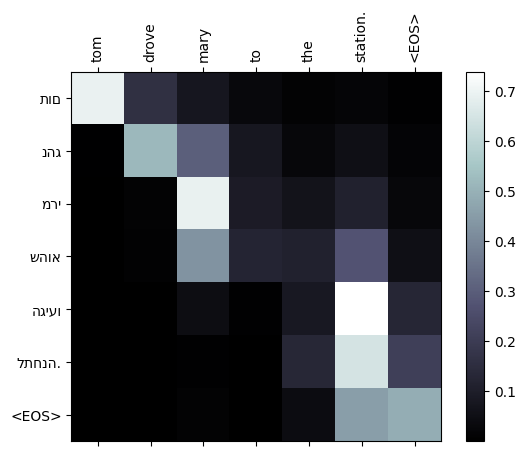

input = i know where they are.
output = אני יודע איפה הם. <EOS>


<ipython-input-10-eb4cf8bbafe5>:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + inp.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-10-eb4cf8bbafe5>:198: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + out_words)


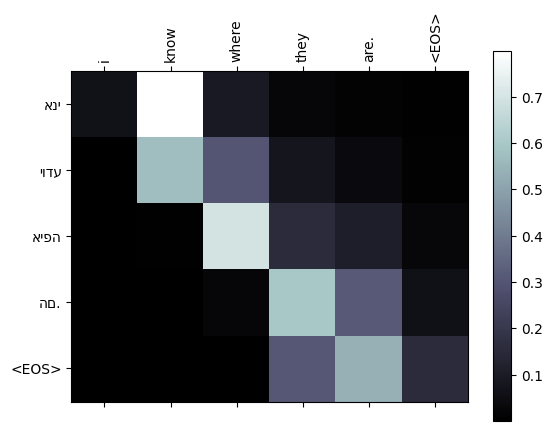

input = can you please pass me the newspaper?
output = העבירי לי שאל את השולחן הזה? <EOS>


<ipython-input-10-eb4cf8bbafe5>:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + inp.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-10-eb4cf8bbafe5>:198: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + out_words)


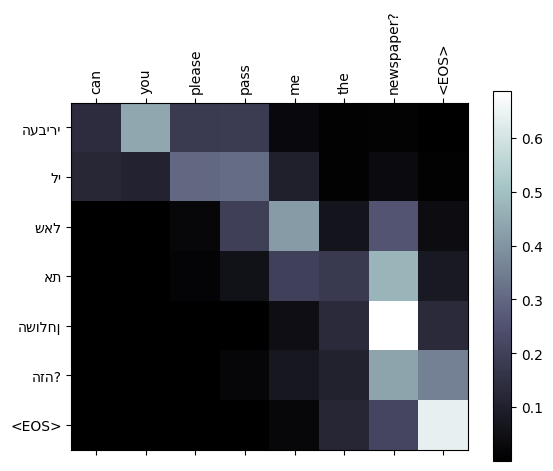

input = tom will be getting anxious.
output = תום יתחיל לדאוג. <EOS>


<ipython-input-10-eb4cf8bbafe5>:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + inp.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-10-eb4cf8bbafe5>:198: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + out_words)


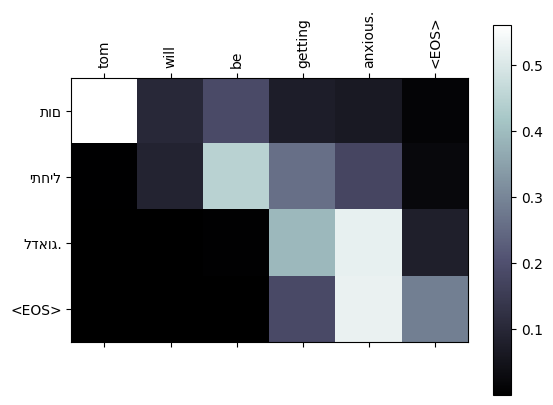

input = it only weighs kilograms.
output = זה שוקל רק שלושה קילוגרמים. <EOS>


<ipython-input-10-eb4cf8bbafe5>:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + inp.split(' ') + ['<EOS>'], rotation=90)
<ipython-input-10-eb4cf8bbafe5>:198: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + out_words)


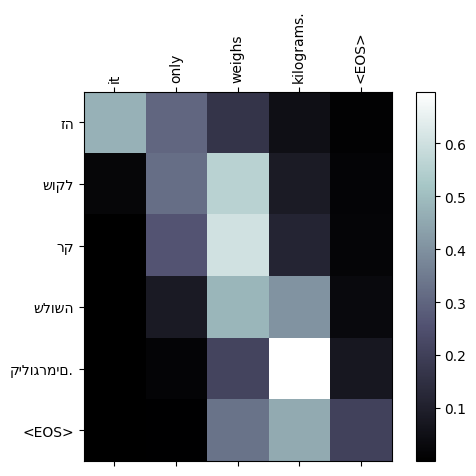

In [ ]:
SOS_token = 0
EOS_token = 1

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')


def readLangs(lang1, lang2, filepath, reverse=False):
    lines = open(filepath, encoding='utf-8').read().strip().split('\n')
    for l in lines:
        s = l.split('\t')
    if reverse:
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

def filterPair(p):
    return (
        len(p[0].split(' ')) < MAX_LENGTH
        and len(p[1].split(' ')) < MAX_LENGTH
    )

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, filepath, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, filepath, reverse)
    pairs = filterPairs(pairs)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    return input_lang, output_lang, pairs

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)
    def forward(self, inp):
        embedded = self.dropout(self.embedding(inp))
        output, hidden = self.gru(embedded)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)
    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2*hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)
    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        bsz = encoder_outputs.size(0)
        dec_inp = torch.empty(bsz, 1, dtype=torch.long, device=device).fill_(SOS_token)
        dec_hid = encoder_hidden
        dec_outs = []
        atts = []
        for i in range(MAX_LENGTH):
            o, dec_hid, att = self.forward_step(dec_inp, dec_hid, encoder_outputs)
            dec_outs.append(o)
            atts.append(att)
            if target_tensor is not None:
                dec_inp = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = o.topk(1)
                dec_inp = topi.squeeze(-1).detach()
        dec_outs = torch.cat(dec_outs, dim=1)
        dec_outs = F.log_softmax(dec_outs, dim=-1)
        atts = torch.cat(atts, dim=1)
        return dec_outs, dec_hid, atts
    def forward_step(self, inp, hid, enc_out):
        emb = self.dropout(self.embedding(inp))
        query = hid.permute(1,0,2)
        ctx, att_w = self.attention(query, enc_out)
        r_inp = torch.cat((emb, ctx), dim=2)
        o, hid = self.gru(r_inp, hid)
        o = self.out(o)
        return o, hid, att_w

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        inp, tgt = data
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        enc_out, enc_hid = encoder(inp)
        dec_out, _, _ = decoder(enc_out, enc_hid, tgt)
        loss = criterion(dec_out.view(-1, dec_out.size(-1)), tgt.view(-1))
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def train_iters(dataloader, encoder, decoder, n_epochs, lr=0.001, print_every=5):
    start = time.time()
    enc_opt = optim.Adam(encoder.parameters(), lr=lr)
    dec_opt = optim.Adam(decoder.parameters(), lr=lr)
    crit = nn.NLLLoss()
    for e in range(1, n_epochs+1):
        loss = train_epoch(dataloader, encoder, decoder, enc_opt, dec_opt, crit)
        if e % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start, e/n_epochs), e, e/n_epochs*100, loss))

def evaluate(encoder, decoder, sentence, in_lang, out_lang):
    with torch.no_grad():
        inp = []
        for w in sentence.split(' '):
            if w in in_lang.word2index:
                inp.append(in_lang.word2index[w])
        inp.append(EOS_token)
        inp = torch.tensor([inp], dtype=torch.long, device=device)
        enc_out, enc_hid = encoder(inp)
        dec_out, _, dec_attn = decoder(enc_out, enc_hid)
        _, topi = dec_out.topk(1)
        dec_ids = topi.squeeze()
        dec_words = []
        for idx in dec_ids:
            if idx.item() == EOS_token:
                dec_words.append('<EOS>')
                break
            dec_words.append(out_lang.index2word[idx.item()])
        return dec_words, dec_attn

def evaluateRandomly(encoder, decoder, pairs, in_lang, out_lang, n=20):
    for _ in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        ow, _ = evaluate(encoder, decoder, pair[0], in_lang, out_lang)
        print('<', ' '.join(ow))
        print()

def showAttention(inp, out_words, att):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(att.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + inp.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + out_words)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def evaluateAndShowAttention(encoder, decoder, sentence, in_lang, out_lang):
    ow, att = evaluate(encoder, decoder, sentence, in_lang, out_lang)
    print('input =', sentence)
    print('output =', ' '.join(ow))
    showAttention(sentence, ow, att[0,:len(ow),:])

input_lang, output_lang, pairs = prepareData('heb', 'eng', '/content/heb.txt')
n = len(pairs)
input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
for i,(inp,tgt) in enumerate(pairs):
    in_w = inp.split(' ')
    t_w = tgt.split(' ')
    in_idx = []
    t_idx = []
    for w in in_w:
        if w in input_lang.word2index:
            in_idx.append(input_lang.word2index[w])
    for w in t_w:
        if w in output_lang.word2index:
            t_idx.append(output_lang.word2index[w])
    in_idx.append(EOS_token)
    t_idx.append(EOS_token)
    in_idx = in_idx[:MAX_LENGTH]
    t_idx = t_idx[:MAX_LENGTH]
    input_ids[i,:len(in_idx)] = in_idx
    target_ids[i,:len(t_idx)] = t_idx

train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=32)
enc = EncoderRNN(input_lang.n_words, hidden_size).to(device)
dec = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
train_iters(train_loader, enc, dec, epochs)
enc.eval()
dec.eval()
evaluateRandomly(enc, dec, pairs, input_lang, output_lang, 20)
for _ in range(5):
    s = random.choice(pairs)[0]
    evaluateAndShowAttention(enc, dec, s, input_lang, output_lang)

**3**

It works for simple sentences but struggles with more complex or long ones. It relies on limited data, uses a single-layer GRU, and has a fixed MAX_LENGTH. It doesn't handle unseen words well and can produce repetitive errors. I’d get more data, use larger or Transformer models.

**4**

In [ ]:
class TransformerSeq2Seq(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers=4, nhead=8, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.embedding_enc = nn.Embedding(input_size, hidden_size)
        self.embedding_dec = nn.Embedding(output_size, hidden_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, MAX_LENGTH, hidden_size))
        self.transformer = nn.Transformer(d_model=hidden_size, nhead=nhead, num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers, dim_feedforward=dim_feedforward, dropout=dropout)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, src, tgt):
        src_emb = self.embedding_enc(src) + self.positional_encoding[:, :src.shape[1], :]
        tgt_emb = self.embedding_dec(tgt) + self.positional_encoding[:, :tgt.shape[1], :]
        src_mask = torch.zeros((src.shape[1], src.shape[1]), device=src.device).type(torch.bool)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.shape[1]).to(tgt.device)
        output = self.transformer(src_emb.permute(1, 0, 2), tgt_emb.permute(1, 0, 2), src_mask=src_mask, tgt_mask=tgt_mask)
        output = self.fc_out(output.permute(1, 0, 2))
        return output

def train_epoch(dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0
    for src, tgt in dataloader:
        optimizer.zero_grad()
        output = model(src, tgt[:, :-1])
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def train_iters(dataloader, model, epochs, lr=0.001, print_every=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    for epoch in range(1, epochs + 1):
        loss = train_epoch(dataloader, model, optimizer, criterion)
        if epoch % print_every == 0:
            print(f"Epoch {epoch}: Loss = {loss:.4f}")

def evaluate(model, sentence, in_lang, out_lang):
    model.eval()
    with torch.no_grad():
        inp = [in_lang.word2index.get(w, 0) for w in sentence.split(' ')] + [EOS_token]
        inp = torch.tensor([inp], dtype=torch.long, device=device)
        tgt = torch.zeros((1, MAX_LENGTH), dtype=torch.long, device=device)
        tgt[:, 0] = SOS_token
        for i in range(1, MAX_LENGTH):
            output = model(inp, tgt[:, :i])
            tgt[:, i] = output[:, -1, :].argmax(dim=-1)
            if tgt[:, i] == EOS_token:
                break
        return ' '.join(out_lang.index2word[t.item()] for t in tgt[0] if t.item() != EOS_token)

train_data = TensorDataset(torch.LongTensor(input_ids).to(device), torch.LongTensor(target_ids).to(device))
train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=32)
model = TransformerSeq2Seq(input_lang.n_words, output_lang.n_words, hidden_size).to(device)
train_iters(train_loader, model, epochs)
for _ in range(5):
    s = random.choice(pairs)[0]
    print('Input:', s)
    print('Output:', evaluate(model, s, input_lang, output_lang))


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 5: Loss = 4.4802
Epoch 10: Loss = 3.3609
Epoch 15: Loss = 2.6659
Epoch 20: Loss = 2.2168
Epoch 25: Loss = 1.9185
Epoch 30: Loss = 1.7306
Epoch 35: Loss = 1.5867
Epoch 40: Loss = 1.4962
Epoch 45: Loss = 1.4159
Epoch 50: Loss = 1.3566
Input: do you like french wine?
Output: SOS אוהבות יין לבן? SOS SOS SOS SOS SOS
Input: that store went bankrupt.
Output: SOS הזה פשט רגל. SOS SOS SOS SOS SOS
Input: quit complaining.
Output: SOS סרב להסיע ציווה ציווה בריאות. SOS SOS SOS
Input: he slept in the car.
Output: SOS במכונית במכונית. SOS SOS SOS SOS SOS SOS
Input: the weather turned bad.
Output: SOS הריע גרוע. SOS SOS SOS SOS SOS SOS


This Transformer-based sequence-to-sequence model should outperform the RNN-based model due to its ability to process input sequences in parallel, better capturing long-term dependencies and handling complex sentence structures more efficiently